# Setup

Data

hoop

0. OR_wx[active_slice]
1. OR_wy[active_slice]
2. OR_wz[active_slice]

femur

3. IB_wx[active_slice]
4. IB_wy[active_slice]
5. IB_wz[active_slice]

tibia

6. IT_wx[active_slice]
7. IT_wy[active_slice]
8. IT_wz[active_slice]

cuneiform

9. IL_wx[active_slice]
10. IL_wy[active_slice]
11. IL_wz[active_slice]




## Packages

In [11]:
import sys
import os

# 1. Get the directory of the current notebook/script.
# If running a notebook in the same directory as network_computation.py, 
# os.getcwd() will point to the correct Parent Directory.
current_dir = os.getcwd() 

# You can also use the hardcoded parent path for absolute certainty:
# current_dir = '/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators/'

# 2. Add this directory to the Python path if it's not already there.
if current_dir not in sys.path:
    sys.path.append(current_dir)
    print(f"Added the project directory to sys.path: {current_dir}")

# Now, subsequent imports should succeed:
# from network_computation import compute_functional_network
# from utils.utils import common_elements

In [12]:
from pathlib import Path
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
import numpy as np
from network_computation import compute_functional_network
from utils.utils import common_elements
from matplotlib.animation import FuncAnimation, PillowWriter
import os # For saving the GIF
from pyunicorn.timeseries.inter_system_recurrence_network import InterSystemRecurrenceNetwork
from process_movella import load_movella
import plotly.graph_objects as go
from plotly.subplots import make_subplots

## Data

In [13]:
# Defining input and output directory

IN_DIR = Path("/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/Hula Hoop/2025-09-03 Experiment 5/2025-09-03 Euler Angles")
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

# Reading sensor data

# OR: hoop
# IB: femur
# IT: tibia
# IL: cuneiform

h_hoop_file = IN_DIR / "OR_20250903_203926.csv"
t_hoop_file = IN_DIR / "IT_20250903_203926.csv"
c_hoop_file = IN_DIR / "IL_20250903_203926.csv"
f_hoop_file = IN_DIR / "IB_20250903_203926.csv"

lead_time_val = 0
h_hoop_data = load_movella(h_hoop_file, lead_time=lead_time_val)
t_hoop_data = load_movella(t_hoop_file, lead_time=lead_time_val)
c_hoop_data = load_movella(c_hoop_file, lead_time=lead_time_val)
f_hoop_data = load_movella(f_hoop_file, lead_time=lead_time_val)

time, _, _, _, h_phi, h_theta, h_psi, h_wx, h_wy, h_wz = h_hoop_data.T
_, _, _, _, t_phi, t_theta, t_psi, t_wx, t_wy, t_wz = t_hoop_data.T
_, _, _, _, c_phi, c_theta, c_psi, c_wx, c_wy, c_wz = c_hoop_data.T
_, _, _, _, f_phi, f_theta, f_psi, f_wx, f_wy, f_wz = f_hoop_data.T

# Derivatives of psi of hoop
h_dpsi_dt = np.sin(h_phi)/np.cos(h_theta)*h_wy+np.cos(h_phi)/np.cos(h_theta)*h_wz

data = np.vstack([time, h_dpsi_dt, time, f_wx, time, f_wy, time, f_wz, time, t_wx, time, t_wy, time, t_wz, time, c_wx, time, c_wy, time, c_wz]).T

# cutting to active region
data = data[694:2588,:]

In [14]:
np.shape(data)

(1894, 20)

In [15]:
h_dpsi_dt

array([-0.00219425,  0.00097289, -0.00154736, ..., -0.42383057,
       -0.43624881, -0.45766579], shape=(2853,))

# Network Analysis On complete data - One Shot

In [16]:
_, _, _, _, _, C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(data, rr=(0.03, 0.03, 0.02), n=10 )

Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating cross recurrence plot at fixed recurrence rate...
Calculating the euclidean distance matrix...
Calculating recurrence plot at fixed recurrence rate...
Calculating the e

In [17]:
np.shape(data)

(1894, 20)

In [18]:
# saving arrays for comparison

FOLDER = "/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators/theresa_rotation_results" # Save network data
os.makedirs(FOLDER, exist_ok=True)


np.save(os.path.join(FOLDER, "data.npy"), data)
np.save(os.path.join(FOLDER, "C_xys.npy"), C_xys)
np.save(os.path.join(FOLDER, "C_yxs.npy"), C_yxs)
np.save(os.path.join(FOLDER, "T_xys.npy"), T_xys)
np.save(os.path.join(FOLDER, "T_yxs.npy"), T_yxs)

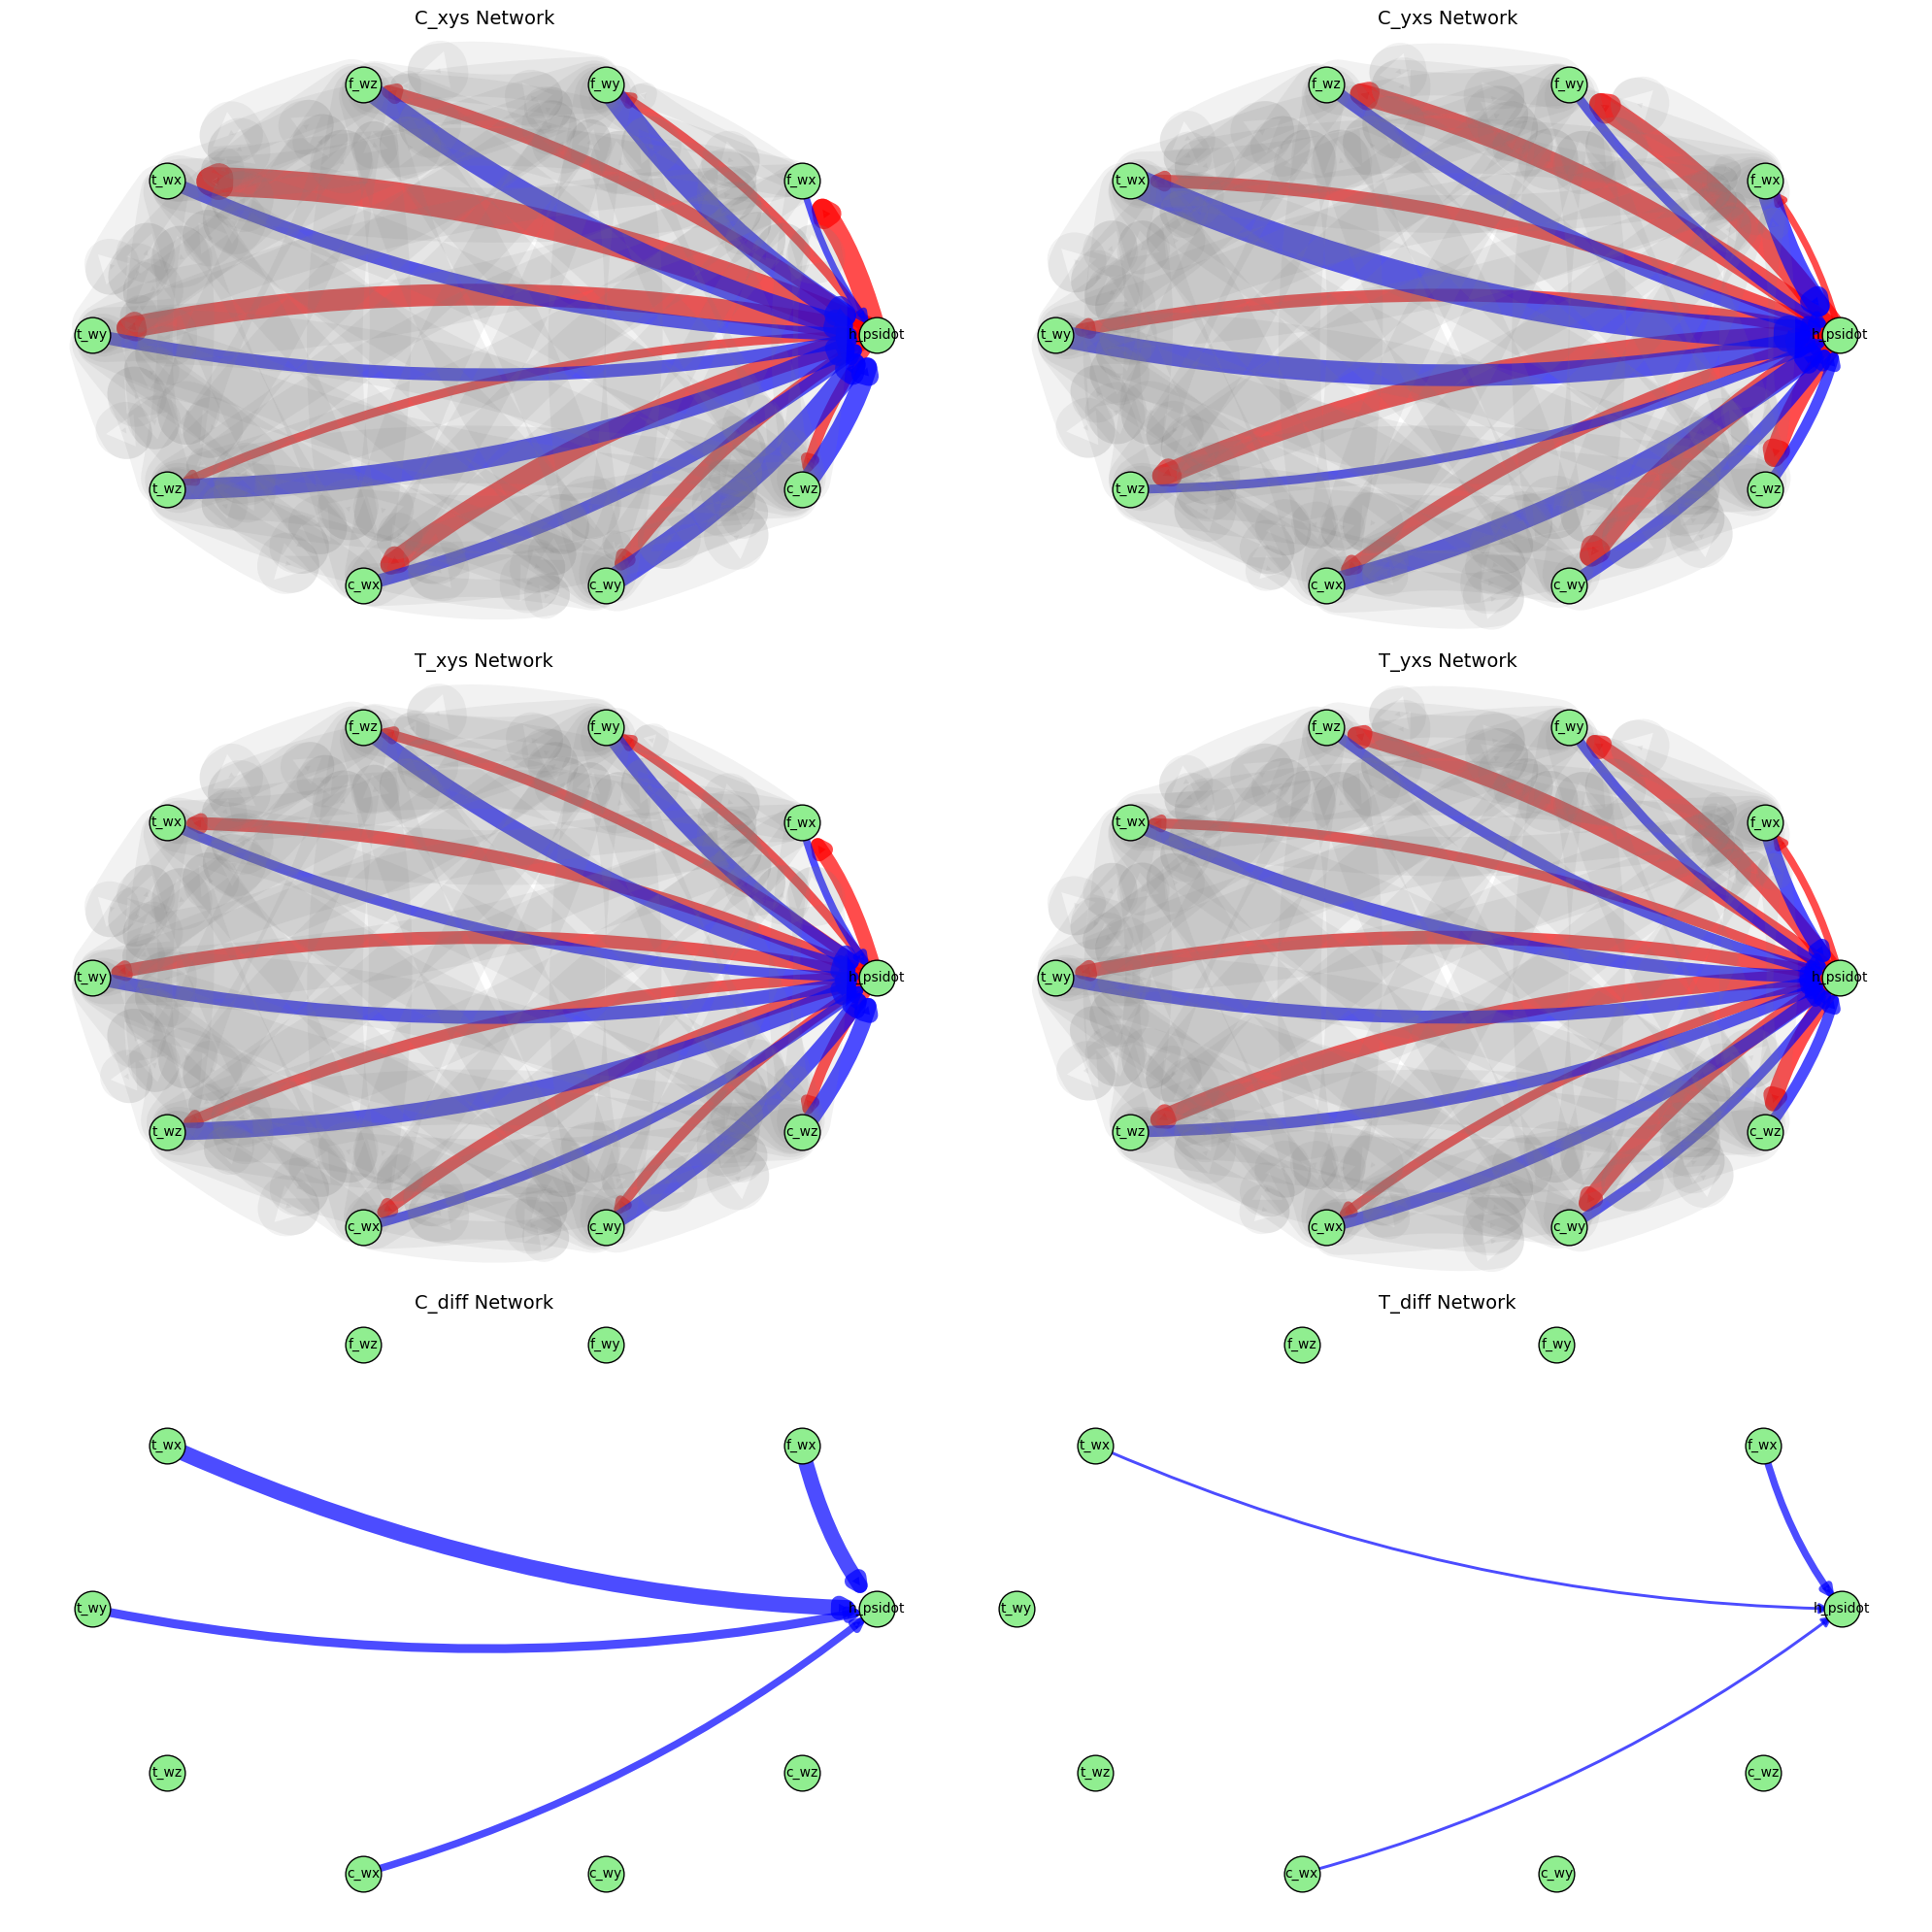

In [ ]:
diff_C = C_xys - C_yxs
diff_T = T_xys - T_yxs

# keeping positive values of body affecting hoop, not hoop affecting body
diff_Cpos = diff_C * (diff_C > 0)
diff_Tpos = diff_T * (diff_T > 0)

# Set all but the first row to 0 to focus on edges from the first node (h_psidot)
diff_Cpos[1:, :] = 0
diff_Tpos[1:, :] = 0

# Transpose to have edges towards h_psidot as they should be for body affecting hoop
diff_Cpos = diff_Cpos.T
diff_Tpos = diff_Tpos.T

# diff_C[np.abs(diff_C) < 0.02] = 0.0
# diff_T[np.abs(diff_T) < 0.02] = 0.0

# Set diagonals to 0
for arr in [C_xys, C_yxs, T_xys, T_yxs]:
    np.fill_diagonal(arr, 0)

networks = [C_xys, C_yxs, T_xys, T_yxs, diff_Cpos, diff_Tpos]
network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network', 'C_diff Network', 'T_diff Network']

# Define the node mapping once
mapping = {
    0: "h_psidot",
    1: "f_wx", 2: "f_wy", 3: "f_wz",
    4: "t_wx", 5: "t_wy", 6: "t_wz", 
    7: "c_wx", 8: "c_wy", 9: "c_wz",   
}
target_nodes = ["h_psidot"]
width_scale = 50.0 

# --- 1. Create Subplots and Loop ---
# Use a larger figure size (e.g., 15x15) to make 4 plots readable
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

# Flatten the 2x2 axes array for easy indexing: axes_flat[0] to axes_flat[3]
axes_flat = axes.flatten()

# Iterate using enumerate to get the index (i) and the array (network_data)
for i, network_data in enumerate(networks):
    
    # Select the current axis to plot on
    ax = axes_flat[i]
    
    # --- Graph Creation and Relabeling (Corrected) ---
    G = nx.DiGraph(network_data) # network_data is the array
    LG = nx.relabel_nodes(G, mapping)
    pos = nx.circular_layout(LG)


    # --- 2. Separate Edges for Coloring (Corrected) ---
    special_edgelist = []  # Edges FROM target_nodes (e.g., 'red')
    special2_edgelist = [] # Edges TO target_nodes (e.g., 'blue')
    other_edgelist = []    # All other edges (e.g., 'gray')
    special_widths = []
    special2_widths = []
    other_widths = []

    # Iterate over all edges in the renamed graph LG
    for u, v, data in LG.edges(data=True):
        weight = data.get('weight', 0)
        
        if weight > 0:
            width = weight * width_scale
            
            is_from_target = u in target_nodes
            is_to_target = v in target_nodes
            
            if is_from_target and not is_to_target:
                special_edgelist.append((u, v))
                special_widths.append(width)
            elif is_to_target and not is_from_target:
                special2_edgelist.append((u, v))
                special2_widths.append(width)
            elif is_from_target and is_to_target:
                 # Handle special case: edge between two target nodes
                special_edgelist.append((u, v))
                special_widths.append(width)
            else:
                other_edgelist.append((u, v))
                other_widths.append(width)


    # --- 3. Draw the Network on the CURRENT AXIS (ax) ---
    
    # 3a. Draw ALL Nodes and Labels
    # Pass the 'ax' parameter to draw on the subplot
    nx.draw_networkx_nodes(
        LG, pos, 
        node_size=700, 
        node_color='lightgreen', 
        edgecolors='black',
        ax=ax # <-- CRITICAL: Draw on the current subplot axis
    )
    nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)


    # 3b. Draw the SPECIAL Edges (FROM target_nodes - Red)
    nx.draw_networkx_edges(
        LG, pos, 
        edgelist=special_edgelist,
        width=special_widths, 
        edge_color='red', 
        alpha=0.7,
        arrowsize=15, 
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )

    # 3c. Draw the SPECIAL2 Edges (TO target_nodes - Blue)
    nx.draw_networkx_edges(
        LG, pos, 
        edgelist=special2_edgelist,
        width=special2_widths, 
        edge_color='blue', 
        alpha=0.7,
        arrowsize=15, 
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )

    # 3d. Draw the OTHER Edges (Gray)
    nx.draw_networkx_edges(
        LG, pos, 
        edgelist=other_edgelist,
        width=other_widths, 
        edge_color='gray', 
        alpha=0.1,
        arrowsize=10, 
        connectionstyle='arc3,rad=0.1',
        ax=ax
    )

    # Set Title and turn off axis for the subplot
    ax.set_title(network_titles[i], fontsize=14)
    ax.axis('off') 


# Adjust layout to prevent overlap and show the figure
plt.tight_layout()
plt.savefig("network_visual_rotation_mix.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Sliding Time Window

In [20]:
# --- GLOBAL PLOTTING CONFIGURATION (Variables used by both functions) ---

network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network']
mapping = {
    0: "h_psidot", 
    1: "f_wx", 2: "f_wy", 3: "f_wz",
    4: "t_wx", 5: "t_wy", 6: "t_wz", 
    7: "c_wx", 8: "c_wy", 9: "c_wz"
}
target_nodes = ["h_psidot"]
width_scale = 5.0 


def draw_single_network(ax, network_data, title, pos, t_start, WINDOW_SIZE):
    """Draws a single network plot on the given axis."""
    
    # Clear the previous drawing
    ax.clear()
    ax.axis('off') # Keep axis off after clearing
    
    # --- Graph Creation and Relabeling ---
    G = nx.DiGraph(network_data)
    LG = nx.relabel_nodes(G, mapping)

    # --- Separate Edges for Coloring ---
    special_edgelist = []
    special2_edgelist = []
    other_edgelist = []
    special_widths = []
    special2_widths = []
    other_widths = []

    for u, v, data in LG.edges(data=True):
        weight = data.get('weight', 0)
        
        if weight > 0:
            width = weight * width_scale
            is_from_target = u in target_nodes
            is_to_target = v in target_nodes
            
            # Grouping logic (simplified)
            if is_from_target:
                special_edgelist.append((u, v))
                special_widths.append(width)
            elif is_to_target:
                special2_edgelist.append((u, v))
                special2_widths.append(width)
            else:
                other_edgelist.append((u, v))
                other_widths.append(width)

    # --- Draw the Network ---
    
    # 1. Draw Nodes and Labels
    nx.draw_networkx_nodes(LG, pos, node_size=700, node_color='lightgreen', edgecolors='black', ax=ax)
    nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)

    # 2. Draw Special Edges (FROM target_nodes - Red)
    nx.draw_networkx_edges(
        LG, pos, edgelist=special_edgelist, width=special_widths, 
        edge_color='red', alpha=0.7, arrowsize=15, 
        connectionstyle='arc3,rad=0.1', ax=ax
    )

    # 3. Draw Special2 Edges (TO target_nodes - Blue)
    nx.draw_networkx_edges(
        LG, pos, edgelist=special2_edgelist, width=special2_widths, 
        edge_color='blue', alpha=0.7, arrowsize=15, 
        connectionstyle='arc3,rad=0.1', ax=ax
    )

    # 4. Draw Other Edges (Gray)
    nx.draw_networkx_edges(
        LG, pos, edgelist=other_edgelist, width=other_widths, 
        edge_color='gray', alpha=0.5, arrowsize=10, 
        connectionstyle='arc3,rad=0.1', ax=ax
    )

    # Set Title and time annotation
    ax.set_title(f"{title}\nTime Window: {t_start}-{t_start + WINDOW_SIZE}", fontsize=12)


def update(frame_index, data2, WINDOW_SIZE, N_NODES, start_indices, 
           axes_flat, network_titles, fixed_pos, 
           all_C_xys, all_C_yxs, all_T_xys, all_T_yxs):
    """
    Function called by FuncAnimation for each frame.
    It calculates the networks for a new time window and updates the plots.
    The accumulation lists (all_C_xys, etc.) are modified in place (by reference).
    """
    t_start = start_indices[frame_index]
    t_end = t_start + WINDOW_SIZE
    
    # 1. Slice the data for the current window
    data_window = data2[t_start:t_end, :]

    # 2. Calculate the four networks
    # This assumes 'compute_functional_network' is available in the environment
    # G, G_, common_G, C_xys, C_yxs, T_xys, T_yxs, RRx, RRy, RRxy = compute_functional_network_th(data_window,th=(0.03, 0.03, 0.02), n=N_NODES )
    _, _, _, _, _, C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(data_window,rr=(0.03, 0.03, 0.02), n=10 )
    
    
    networks_data = [C_xys, C_yxs, T_xys, T_yxs]

    # --- APPEND MATRICES TO THE ACCUMULATION LISTS (Passed by Reference) ---
    all_C_xys.append(C_xys)
    all_C_yxs.append(C_yxs)
    all_T_xys.append(T_xys)
    all_T_yxs.append(T_yxs)

    # 3. Redraw all four subplots
    for i in range(4):
        ax = axes_flat[i]
        network_data = networks_data[i]
        title = network_titles[i]
        
        # Pass WINDOW_SIZE to the draw function
        draw_single_network(ax, network_data, title, fixed_pos, t_start, WINDOW_SIZE)
    
    # Return the updated artists (necessary for FuncAnimation)
    return axes_flat


def get_sliding_window_animation(data2, WINDOW_SIZE = 20, STEP_SIZE = 5):
    '''
    get animation of sliding window saving the thickness of the network

        WINDOW_SIZE: Number of time points in the sliding window
        STEP_SIZE: How much the window shifts per frame (fewer steps = faster animation)
    '''
    
    # Number of nodes
    # Check shape compatibility
    if np.shape(data2)[1] % 2 != 0:
        raise ValueError("The number of columns in data2 must be even (2 * N_NODES).")
        
    N_NODES = int(np.shape(data2)[1]/2)


    # --- ANIMATION PARAMETERS ---
    TOTAL_TIME_POINTS = np.shape(data2)[0]
    FPS = 10             # Frames per second for the final GIF

    # Calculate the start indices for each frame
    start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
    NUM_FRAMES = len(start_indices)

    if NUM_FRAMES == 0:
        print("Warning: Data is too short or window/step size is too large to generate any frames.")
        return None, None, None, None

    # Prepare the figure and axes once
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    axes_flat = axes.flatten()

    # Pre-calculate the fixed circular layout
    dummy_G = nx.DiGraph(np.zeros((N_NODES, N_NODES)))
    dummy_LG = nx.relabel_nodes(dummy_G, mapping)
    fixed_pos = nx.circular_layout(dummy_LG)

    # These lists will store the (N x N) matrices for each time window (frame).
    all_C_xys = []
    all_C_yxs = []
    all_T_xys = []
    all_T_yxs = []

    # --- 3. Run and Save the Animation ---

    print(f"Generating animation with {NUM_FRAMES} frames...")

    # Define the arguments (fargs) that need to be passed to the update function
    fargs_tuple = (
        data2, WINDOW_SIZE, N_NODES, start_indices, 
        axes_flat, network_titles, fixed_pos, 
        all_C_xys, all_C_yxs, all_T_xys, all_T_yxs # <-- The lists are included here!
    )
    
    anim = FuncAnimation(
        fig, 
        update, 
        frames=NUM_FRAMES,
        fargs=fargs_tuple, # <-- Pass the contextual arguments and the lists
        blit=False,  
        interval=1000/FPS 
    )
        
    # Set save path
    animation_filename = 'network_evolution_rotation_mix.mp4'

    # Create writer
    writer = FFMpegWriter(fps=FPS)

    # Save animation as MP4
    anim.save(animation_filename, writer=writer)

    plt.close(fig) # Close the figure to free up memory
    print(f"Animation saved as {animation_filename}")

    # --- CONVERT LISTS TO NUMPY ARRAYS AND SAVE ---
    # The lists are now filled because the update function modified them in place.

    # Convert the lists of matrices into 3D NumPy arrays (Frames x Nodes x Nodes)
    C_xys_3D = np.array(all_C_xys)
    C_yxs_3D = np.array(all_C_yxs)
    T_xys_3D = np.array(all_T_xys)
    T_yxs_3D = np.array(all_T_yxs)

    # Save the 3D arrays to disk
    np.save('C_xys_matrices.npy', C_xys_3D)
    np.save('C_yxs_matrices.npy', C_yxs_3D)
    np.save('T_xys_matrices.npy', T_xys_3D)
    np.save('T_yxs_matrices.npy', T_yxs_3D)

    print("\n--- Matrix Data Saved ---")
    print(f"Shape of saved matrices ({NUM_FRAMES} frames x {N_NODES} nodes x {N_NODES} nodes): ({C_xys_3D.shape})")
    print(f"Matrices saved as:\n  - C_xys_matrices.npy\n  - C_yxs_matrices.npy\n  - T_xys_matrices.npy\n  - T_yxs_matrices.npy")

    return C_xys_3D, C_yxs_3D, T_xys_3D, T_yxs_3D

In [21]:
C_xys_3D, C_yxs_3D, T_xys_3D, T_yxs_3D = get_sliding_window_animation(data, WINDOW_SIZE = 60, STEP_SIZE = 10)

IndexError: tuple index out of range

In [ ]:
# --- Relabeling Logic for Index i (2 to 10) ---
i_start = 1
i_end = 10 # Up to (but not including) 11, so indices are 2, 3, ..., 10
i_values = np.array(['wx_femur', 'wy_femur', 'wz_femur', 'wx_tibia', 'wy_tibia', 'wz_tibia','wx_cuneiform', 'wy_cuneiform', 'wz_cuneiform']) #np.arange(i_start, i_end)
i_labels = [str(i) for i in i_values]

# Data extraction (slicing the third dimension from index 2 up to 11)
data_C0 = C_xys_3D[:, 0, i_start:i_end]
data_T0 = T_xys_3D[:, 0, i_start:i_end]
data_C2 = C_yxs_3D[:, 0, i_start:i_end]
data_T2 = T_yxs_3D[:, 0, i_start:i_end]
data_C4 = C_xys_3D[:, 0, i_start:i_end] - C_xys_3D[:, i_start:i_end, 0] # C_xys_3D[:, 0, i_start:i_end]-C_yxs_3D[:, 0, i_start:i_end]
data_T4 = T_xys_3D[:, 0, i_start:i_end] - T_xys_3D[:, i_start:i_end, 0] # T_xys_3D[:, 0, i_start:i_end]-T_yxs_3D[:, 0, i_start:i_end]

# List of all data arrays, their titles, and labels for plotting
heatmap_info = [
    (data_C0, '$C_{xy}$ (psidot_hoop)', '$C_{xy}$'),
    (data_T0, '$T_{xy}$ (psidot_hoop)', '$T_{xy}$'),
    (data_C2, '$C_{yx}$ (psidot_hoop)', '$C_{yx}$'),
    (data_T2, '$T_{yx}$ (psidot_hoop)', '$T_{yx}$'),
    (data_C4, '$diff_C$ (psidot_hoop)', '$C_{xy}-C_{yx}$'),
    (data_T4, '$diff_T$ (psidot_hoop)', '$T_{xy}-T_{yx}$'),
]

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

x_label = 'Slice Index'
y_label = 'Index $i$'
# super_title = f'Heatmaps for Timewindow = {nframes} frames'

# fig.suptitle(super_title, fontsize=16)

for idx, (data_angle_derivatives, base_title, cbar_label) in enumerate(heatmap_info):
    ax = axes[idx]

    # Transpose the data (data.T) so 'Slice' is on X-axis and 'i' is on Y-axis.
    # origin='lower' ensures i=2 is at the bottom and i=10 is at the top.

    masked_data = np.ma.masked_less(data_angle_derivatives.T,0)
    im = ax.imshow(masked_data, aspect='auto', origin='lower', cmap='viridis', interpolation='none')

    # --- Setting the Y-axis ticks/labels (Index i: 2-10) ---
    # The tick locations are 0 to 8, corresponding to the 9 indices in i_values.
    ax.set_yticks(np.arange(len(i_values)))
    ax.set_yticklabels(i_labels)
    # --------------------------------------------------------

    # --- ADDING SEPARATION LINES BETWEEN ROWS ---
    # Lines are drawn at k + 0.5, which falls between cell k and cell k+1.
    for k in range(len(i_values) - 1):
        ax.axhline(y=k + 0.5, color='white', linewidth=1.5)
    # --------------------------------------------

    intervals = np.linspace(0,184,22) # 22 lines to create 21 intervals, adjust the end value as needed
    # intervals = np.linspace(0,1894/,22)
    

    for x in intervals:
        ax.axvline(x=x, color='red', linestyle='--', linewidth=1)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(base_title)

    # Add a colorbar
    plt.colorbar(im, ax=ax, label=cbar_label)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# To save the figure, uncomment the line below:
plt.savefig('heatmaps_rotation_mix.pdf')
# plt.show()

In [ ]:
names = [
    None,        # dummy so index matches i
    'femur_wx',
    'femur_wy',
    'femur_wz',
    'tibia_wx',
    'tibia_wy',
    'tibia_wz',
    'cuneiform_wx',
    'cuneiform_wy',
    'cuneiform_wz'
]

In [ ]:
plt.figure()

diff_sum = np.zeros(np.shape(C_xys_3D)[0])
pos_count = np.zeros(np.shape(C_xys_3D)[0])

for i in range(1, 10):
    diff = C_xys_3D[:, 0, i] - C_xys_3D[:, i, 0]
    pos = diff > 0

    diff_sum[pos] += diff[pos]
    pos_count[pos] += 1

    plt.plot(
        np.where(pos, diff, np.nan),
        label=names[i]
    )

# avg_positive = diff_sum / pos_count
avg_positive = diff_sum / 9
avg_positive[pos_count == 0] = np.nan  # avoid divide-by-zero

plt.plot(avg_positive, 'k', linewidth=2, label='avg positive')
plt.legend()


plt.figure()
plt.plot(pos_count, marker='.', linestyle='None')
plt.show()

# Animations

In [ ]:
# # --- ANIMATION PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data2[:500,:])[0]
# WINDOW_SIZE = 100    # Number of time points in the sliding window
# STEP_SIZE = 10        # How much the window shifts per frame (fewer steps = faster animation)
# FPS = 10             # Frames per second for the final GIF

# # Calculate the start indices for each frame
# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# # --- GLOBAL PLOTTING CONFIGURATION (from your code) ---
# network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network']
# mapping = {
#     0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz", 
#     6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"
# }
# target_nodes = ["h_wx", "h_wy", "h_wz"]
# width_scale = 5.0 

# # Prepare the figure and axes once
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# axes_flat = axes.flatten()

# # Pre-calculate the fixed circular layout (should not change over time)
# # We use a dummy graph just to get the node ordering for the layout.
# dummy_G = nx.DiGraph(np.zeros((12, 12)))
# dummy_LG = nx.relabel_nodes(dummy_G, mapping)
# fixed_pos = nx.circular_layout(dummy_LG)

# # Define a single function to draw a network on a specific axis
# def draw_single_network(ax, network_data, title, pos, t_start):
#     """Draws a single network plot on the given axis."""
    
#     # Clear the previous drawing
#     ax.clear()
#     ax.axis('off') # Keep axis off after clearing
    
#     # --- Graph Creation and Relabeling ---
#     G = nx.DiGraph(network_data)
#     LG = nx.relabel_nodes(G, mapping)

#     # --- Separate Edges for Coloring ---
#     special_edgelist = []
#     special2_edgelist = []
#     other_edgelist = []
#     special_widths = []
#     special2_widths = []
#     other_widths = []

#     for u, v, data in LG.edges(data=True):
#         weight = data.get('weight', 0)
        
#         if weight > 0:
#             width = weight * width_scale
#             is_from_target = u in target_nodes
#             is_to_target = v in target_nodes
            
#             # Grouping logic (simplified)
#             if is_from_target:
#                 special_edgelist.append((u, v))
#                 special_widths.append(width)
#             elif is_to_target:
#                 special2_edgelist.append((u, v))
#                 special2_widths.append(width)
#             else:
#                 other_edgelist.append((u, v))
#                 other_widths.append(width)

#     # --- Draw the Network ---
    
#     # 1. Draw Nodes and Labels
#     nx.draw_networkx_nodes(LG, pos, node_size=700, node_color='lightgreen', edgecolors='black', ax=ax)
#     nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)

#     # 2. Draw Special Edges (FROM target_nodes - Red)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special_edgelist, width=special_widths, 
#         edge_color='red', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 3. Draw Special2 Edges (TO target_nodes - Blue)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special2_edgelist, width=special2_widths, 
#         edge_color='blue', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 4. Draw Other Edges (Gray)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=other_edgelist, width=other_widths, 
#         edge_color='gray', alpha=0.5, arrowsize=10, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # Set Title and time annotation
#     ax.set_title(f"{title}\nTime Window: {t_start}-{t_start + WINDOW_SIZE}", fontsize=12)

# # --- 2. The Update Function for the Animation ---
# def update(frame_index):
#     """
#     Function called by FuncAnimation for each frame.
#     It calculates the networks for a new time window and updates the plots.
#     """
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
    
#     # 1. Slice the data for the current window
#     data_window = data2[t_start:t_end, :]

#     # 2. Calculate the four networks
#     # The output is (C_xys, C_yxs, T_xys, T_yxs) as per your setup

#     G, G_, common_G, C_xys, C_yxs, T_xys, T_yxs, rrx, rrxy = compute_functional_network_th(data_window,th=(0.1, 0.1, 0.05), n=np.shape(data_angle_derivatives)[1] )
    

#     # G, G_, common_G, T_diff, C_diff, C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#     #     data_window, 
#     #     (0.06, 0.06, 0.02), 
#     #     C_threshold=0.02, 
#     #     T_threshold=0.02, 
#     #     n=np.shape(data)[1]
#     # )

#     networks_data = [C_xys, C_yxs, T_xys, T_yxs]
#     print(np.shape(networks_data))

#     # 3. Redraw all four subplots
#     for i in range(4):
#         ax = axes_flat[i]
#         network_data = networks_data[i]
#         title = network_titles[i]
        
#         draw_single_network(ax, network_data, title, fixed_pos, t_start)
    
#     # Return the updated artists (necessary for FuncAnimation)
#     return axes_flat

# # --- 3. Run and Save the Animation ---
# print(f"Generating animation with {NUM_FRAMES} frames...")

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=NUM_FRAMES,
#     blit=False,  # Set to False, as NetworkX often doesn't handle blitting well
#     interval=1000/FPS # Delay between frames in ms
# )

# # Set the save path
# animation_filename = 'network_evolution.gif'

# # Save the animation as a GIF
# writer = PillowWriter(fps=FPS)
# anim.save(animation_filename, writer=writer)

# plt.close(fig) # Close the figure to free up memory
# print(f"Animation saved as {animation_filename}")

In [ ]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
# import os # For saving the GIF

# # --- ANIMATION PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data_angle_derivatives)[0]
# WINDOW_SIZE = 100    # Number of time points in the sliding window
# STEP_SIZE = 5        # How much the window shifts per frame (fewer steps = faster animation)
# FPS = 10             # Frames per second for the final GIF

# # Calculate the start indices for each frame
# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# # --- GLOBAL PLOTTING CONFIGURATION (from your code) ---
# network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network']
# mapping = {
#     0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz", 
#     6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"
# }
# target_nodes = ["h_wx", "h_wy", "h_wz"]
# width_scale = 5.0 

# # Prepare the figure and axes once
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# axes_flat = axes.flatten()

# # Pre-calculate the fixed circular layout (should not change over time)
# # We use a dummy graph just to get the node ordering for the layout.
# dummy_G = nx.DiGraph(np.zeros((12, 12)))
# dummy_LG = nx.relabel_nodes(dummy_G, mapping)
# fixed_pos = nx.circular_layout(dummy_LG)

# # Define a single function to draw a network on a specific axis
# def draw_single_network(ax, network_data, title, pos, t_start):
#     """Draws a single network plot on the given axis."""
    
#     # Clear the previous drawing
#     ax.clear()
#     ax.axis('off') # Keep axis off after clearing
    
#     # --- Graph Creation and Relabeling ---
#     G = nx.DiGraph(network_data)
#     LG = nx.relabel_nodes(G, mapping)

#     # --- Separate Edges for Coloring ---
#     special_edgelist = []
#     special2_edgelist = []
#     other_edgelist = []
#     special_widths = []
#     special2_widths = []
#     other_widths = []

#     for u, v, data in LG.edges(data=True):
#         weight = data.get('weight', 0)
        
#         if weight > 0:
#             width = weight * width_scale
#             is_from_target = u in target_nodes
#             is_to_target = v in target_nodes
            
#             # Grouping logic (simplified)
#             if is_from_target:
#                 special_edgelist.append((u, v))
#                 special_widths.append(width)
#             elif is_to_target:
#                 special2_edgelist.append((u, v))
#                 special2_widths.append(width)
#             else:
#                 other_edgelist.append((u, v))
#                 other_widths.append(width)

#     # --- Draw the Network ---
    
#     # 1. Draw Nodes and Labels
#     nx.draw_networkx_nodes(LG, pos, node_size=700, node_color='lightgreen', edgecolors='black', ax=ax)
#     nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)

#     # 2. Draw Special Edges (FROM target_nodes - Red)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special_edgelist, width=special_widths, 
#         edge_color='red', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 3. Draw Special2 Edges (TO target_nodes - Blue)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special2_edgelist, width=special2_widths, 
#         edge_color='blue', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 4. Draw Other Edges (Gray)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=other_edgelist, width=other_widths, 
#         edge_color='gray', alpha=0.5, arrowsize=10, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # Set Title and time annotation
#     ax.set_title(f"{title}\nTime Window: {t_start}-{t_start + WINDOW_SIZE}", fontsize=12)

# # --- 2. The Update Function for the Animation ---
# def update(frame_index):
#     """
#     Function called by FuncAnimation for each frame.
#     It calculates the networks for a new time window and updates the plots.
#     """
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
    
#     # 1. Slice the data for the current window
#     data_window = data_angle_derivatives[t_start:t_end, :]

#     # 2. Calculate the four networks
#     # The output is (C_xys, C_yxs, T_xys, T_yxs) as per your setup
#     C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#         data_window, 
#         (0.06, 0.06, 0.02), 
#         C_threshold=0.02, 
#         T_threshold=0.02, 
#         n=10
#     )
    
#     networks_data = [C_xys, C_yxs, T_xys, T_yxs]

#     # 3. Redraw all four subplots
#     for i in range(4):
#         ax = axes_flat[i]
#         network_data = networks_data[i]
#         title = network_titles[i]
        
#         draw_single_network(ax, network_data, title, fixed_pos, t_start)
    
#     # Return the updated artists (necessary for FuncAnimation)
#     return axes_flat

# # --- 3. Run and Save the Animation ---
# print(f"Generating animation with {NUM_FRAMES} frames...")

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=NUM_FRAMES,
#     blit=False,  # Set to False, as NetworkX often doesn't handle blitting well
#     interval=1000/FPS # Delay between frames in ms
# )

# # Set the save path
# animation_filename = 'network_evolution.gif'

# # Save the animation as a GIF
# writer = PillowWriter(fps=FPS)
# anim.save(animation_filename, writer=writer)

# plt.close(fig) # Close the figure to free up memory
# print(f"Animation saved as {animation_filename}")

In [ ]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter

# # --- PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data_angle_derivatives)[0]
# WINDOW_SIZE = 100
# STEP_SIZE = 5
# FPS = 10

# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# mapping = {0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz",
#            6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"}
# target_nodes = ["h_wx", "h_wy", "h_wz"]

# # --- RECORD HOOP CONNECTIONS ---
# C_xys_hoop_series = []
# T_xys_hoop_series = []

# # --- FUNCTION TO EXTRACT HOOP CONNECTION VALUES ---
# def extract_hoop_connections(matrix):
#     """
#     Extract all rows/columns corresponding to hoop nodes (target_nodes)
#     and flatten them into a single vector of values.
#     """
#     indices = [k for k, v in mapping.items() if v in target_nodes]
#     # Take all connections from/to hoop nodes
#     hoop_values = matrix[indices, :].flatten()
#     hoop_values = np.append(hoop_values, matrix[:, indices].flatten())
#     return hoop_values

# # --- ANIMATION UPDATE FUNCTION ---
# def update(frame_index):
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
#     data_window = data_angle_derivatives[t_start:t_end, :]

#     C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#         data_window, (0.06, 0.06, 0.02), C_threshold=0.02, T_threshold=0.02, n=np.shape(data_angle_derivatives)[1]
#     )

#     # Record hoop connection values
#     C_xys_hoop_series.append(extract_hoop_connections(C_xys))
#     T_xys_hoop_series.append(extract_hoop_connections(T_xys))

#     # --- OPTIONAL: draw animation frames if needed ---
#     return []

# # --- RUN ANIMATION TO COLLECT DATA ---
# for i in range(NUM_FRAMES):
#     update(i)

# # Convert to arrays: rows = time windows, columns = different hoop connections
# C_xys_hoop_series = np.array(C_xys_hoop_series)
# T_xys_hoop_series = np.array(T_xys_hoop_series)

# # --- PLOT TIME SERIES ---
# time_windows = start_indices
# plt.figure(figsize=(12, 6))
# plt.plot(time_windows, C_xys_hoop_series.mean(axis=1), label='C_xys (hoop connections)')
# plt.plot(time_windows, T_xys_hoop_series.mean(axis=1), label='T_xys (hoop connections)')
# plt.xlabel("Time window start index")
# plt.ylabel("Average connection weight")
# plt.title("Time series of C_xys and T_xys connecting to hoop nodes")
# plt.legend()
# plt.grid(True)
# plt.show()
